In [1]:
import pandas as pd 
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from src.files.fasta import FASTAFile
from Bio import Phylo
from itertools import product, combinations
from utils import *
from src.coevolution import get_scores
from scipy.stats import mannwhitneyu
from src.files.itol import *

is_homogenous = lambda df : df.category.nunique() == 1

In [ ]:
# Want to compare the regions where the divergence scores are highest. Would expect to see higher divergence scores around
# the N-terminus when comparing Pyl+ vs. Pyl-. Probably should control for evolutionary distance, i.e. compare clades which are similarly
# distant. Probably the easiest way to do this is by clustering the release factors and then building a tree of the representatives. 

arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)
# build_stop_codon_genome_metadata_dataset(arf1_df.genome_id.unique())
stop_codon_genome_metadata_df = pd.read_csv('../data/stop_codon.csv', index_col=0)

arf1_df['tag_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id').TAG.first())
arf1_df['stop_codon_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id')['total'].first())
arf1_df['tag_percent'] = arf1_df.tag_count / arf1_df.stop_codon_count


# I think more granular categories could be helpful:
# (1) Pyl+ and largely re-coded (TAG < 5%)
# (2) Pyl+ which still use lots of TAG stops (TAG > 5%) 
# (3) Pyl- (including the weird outliers

masks = dict()
masks['pyl+ recoded'] = (arf1_df.tag_percent < 0.05) & (arf1_df.has_pyl)
masks['pyl+'] = (arf1_df.tag_percent >= 0.05) & (arf1_df.has_pyl)
masks['pyl-'] = (~arf1_df.has_pyl)

categories = list(masks.keys())
arf1_df['category'] = np.select([masks[category] for category in categories], categories, default='none')

In [3]:
cluster_df = pd.read_csv('../data/arf1_cleaned_cluster.tsv', sep='\t', names=['rep_id', 'id'])
cluster_df = cluster_df.set_index('id')
cluster_ids = {rep_id:i for i, rep_id in enumerate(cluster_df.rep_id.unique())}
cluster_df['cluster_id'] = cluster_df.rep_id.map(cluster_ids)
cluster_df['representative'] = cluster_df.index == cluster_df.rep_id
cluster_df['cluster_size'] = cluster_df.cluster_id.map(cluster_df.groupby('cluster_id').size())
cluster_df['category'] = arf1_df.category
cluster_df['order'] = arf1_df.order
cluster_df['genus'] = arf1_df.genus
cluster_df['seq'] = arf1_df.seq
print('Num. clusters:', cluster_df.rep_id.nunique())

Num. clusters: 647


In [4]:
arf1_df.columns

Index(['description', 'seq', 'length', 'partial', 'Unnamed: 0', 'query_name',
       'e_value', 'query_coords', 'target_coords', 'envelope_coords',
       'target_length', 'query_length', 'n_hits', 'genome_id', 'max_e_value',
       'has_pyl', 'query_alignment_start', 'biggest_query_gap',
       'biggest_target_gap', 'alignment_length', 'genus', 'order',
       'has_niks_domain', 'has_ycf_domain', 'tag_count', 'stop_codon_count',
       'tag_percent', 'category'],
      dtype='object')

In [5]:
min_cluster_size = 5
print(f'Num. clusters with size > {min_cluster_size}:', (cluster_df.groupby('cluster_id').size() > min_cluster_size).sum())
cluster_df = cluster_df[cluster_df.cluster_size > min_cluster_size].copy()

print('Num. homogenous clusters:', cluster_df.groupby('cluster_id').apply(is_homogenous, include_groups=False).sum())
cluster_df['homogenous'] = cluster_df.cluster_id.map(cluster_df.groupby('cluster_id').apply(is_homogenous, include_groups=False))
cluster_df = cluster_df[cluster_df.homogenous].copy()
cluster_rep_df = cluster_df[cluster_df.representative].copy()

FASTAFile().from_df(cluster_df[cluster_df.representative]).write('../data/arf1_cleaned_rep_seq.fasta')

# ! ~/muscle5.1.linux_intel64 -align ../data/arf1_cleaned_rep_seq.fasta -output ../data/arf1_cleaned_rep_seq.afa
# ! fasttree ../data/arf1_cleaned_rep_seq.afa > ../data/arf1_cleaned_rep_seq.tree

Num. clusters with size > 5: 89
Num. homogenous clusters: 80


In [6]:
tree = Phylo.read('../data/arf1_cleaned_rep_seq.tree', 'newick')

rep_ids = cluster_rep_df.index.unique()
d = pd.DataFrame(columns=rep_ids, index=rep_ids)

# for id_1, id_2 in product(rep_ids, repeat=2):
#     dist = tree.distance(tree.find_any(id_1), tree.find_any(id_2))
#     d.loc[id_1, id_2] = dist

pair_df = list()
max_dist, min_dist = 0.9, 0.6
for id_1, id_2 in combinations(rep_ids, 2):
    dist = tree.distance(tree.find_any(id_1), tree.find_any(id_2))
    if (dist > min_dist) and (dist < max_dist):
        row = dict()
        row['id_1'], row['id_2'] = id_1, id_2
        row['category_1'], row['category_2'] = arf1_df.loc[id_1].category, arf1_df.loc[id_2].category
        row['cluster_id_1'], row['cluster_id_2'] = cluster_df.loc[id_1].cluster_id, cluster_df.loc[id_2].cluster_id
        row['distance'] = dist
        pair_df.append(row)

pair_df = pd.DataFrame(pair_df)
pair_df['pair_category'] = [' vs. '.join(sorted([row.category_1, row.category_2])) for row in pair_df.itertuples()]

In [7]:
figure_df = list()
# for row in pair_df[pair_df.pair_category.isin(palette.keys())].itertuples():

for row in pair_df.itertuples():
    ids = cluster_df[cluster_df.cluster_id.isin([row.cluster_id_1, row.cluster_id_2])].index
    index, alignment = load_msa(path='../data/arf1_cleaned.afa', conservation_threshold=0.9, ids=ids) # Should load the sequences from Methanosarcinales only. 
    # positions = positions_ if (positions is None) else positions 

    alignment_df = pd.DataFrame(alignment, index=index)
    alignment_df['cluster_id'] = cluster_df.cluster_id
    scores = get_scores(alignment_df, group_by='cluster_id', normalize=True)
    # sns.lineplot(x=np.arange(len(scores)), y=scores, color=palette[row.pair_category])
    positions = np.arange(len(scores))[scores > 0.95]
    df = pd.DataFrame(pd.Series(positions, name='highest_score_positions'))
    df['pair_category'] = row.pair_category
    df['alignment_length'] = alignment.shape[-1]
    figure_df.append(df)
figure_df = pd.concat(figure_df)

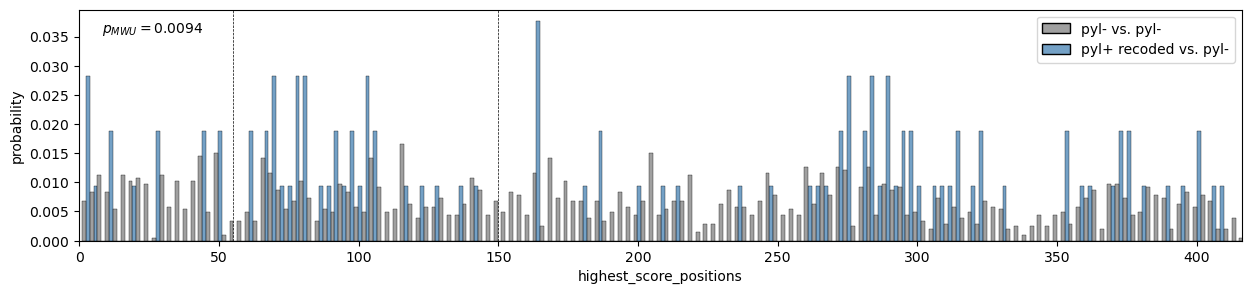

In [8]:

fig, ax = plt.subplots(figsize=(15, 3))
palette = {'pyl- vs. pyl-':'gray', 'pyl+ recoded vs. pyl-':'steelblue'}
# palette = {'pyl- vs. pyl-':'gray', 'pyl+ recoded vs. pyl-':'steelblue', 'pyl+ vs. pyl-':'lightgray'}

# sns.kdeplot(figure_df[figure_df.pair_category.isin(palette.keys())], ax=ax, x='highest_score_positions', hue='pair_category', common_norm=False, bw_adjust=0.1, palette=palette)
sns.histplot(figure_df[figure_df.pair_category.isin(palette.keys())], ax=ax, x='highest_score_positions', hue='pair_category', common_norm=False, bins=150, stat='probability', palette=palette, multiple='dodge')
sns.move_legend(ax, loc='upper right')
ax.legend_.set_title('')
ax.set_xlim(xmin=0, xmax=416)
ax.set_ylabel('probability')

min_position, max_position = 55, 150
values_1 = figure_df[figure_df.pair_category == 'pyl+ recoded vs. pyl-'].highest_score_positions.values
values_2 = figure_df[figure_df.pair_category == 'pyl- vs. pyl-'].highest_score_positions.values

values_1 = values_1[(values_1 > min_position) & (values_1 < max_position)]
values_2 = values_2[(values_2 > min_position) & (values_2 < max_position)]
stat, p = mannwhitneyu(values_1, values_2, alternative='two-sided')
ax.text(0.02, 0.9, '$p_{MWU}=$' + f'{p:.4f}', transform=ax.transAxes)

ax.axvline(min_position, color='black', ls='--', lw=0.5)
ax.axvline(max_position, color='black', ls='--', lw=0.5)

plt.show()
# https://pmc.ncbi.nlm.nih.gov/articles/PMC3795251/



In [9]:
# Want to create an annotation file where the orders are annotated. Need to get the internal node shared by all genus members. 
tree = Phylo.read('../data/arf1_cleaned_rep_seq.tree', 'newick')

# First need to label the internal nodes. 
for order, df in cluster_rep_df.groupby('order'):
    order_ids = df.index.tolist()
    clades = [tree.find_any(id_) for id_ in order_ids]
    lca = tree.common_ancestor(clades)
    lca.confidence = None # Prevents Biopython from interpreting the names as floats, for some reason. 
    lca.name = order
Phylo.write(tree, '../data/arf1_cluster_rep_seq_with_order_labels.tree', format='newick')

1

In [10]:
lines = ['DATASET_TEXT']
lines += ['SEPARATOR COMMA']
lines += ['DATASET_LABEL,dataset']
lines += ['COLOR,#ff0000']
lines += ['MARGIN,0'] # Left margin, used to increase/decrease the spacing to the next dataset.
lines += ['SHOW_INTERNAL,1'] # If set, text labels associated to internal nodes will be displayed even if these nodes are not collapsed. It could cause overlapping in the dataset display.
lines += ['ALL_LABELS_ROTATION,0'] # Rotate all labels by the specified angle
lines += ['LABELS_BELOW,1'] # By default, internal labels will be placed above the branches. If LABELS_BELOW is set to 1, labels will be below the branches
lines += ['VERTICAL_SHIFT,0'] # Shift internal labels vertically by this amount of pixels (positive or negative)
lines += ['STRAIGHT_LABELS,0'] # If set to 1, tree rotation will not influence the individual label rotation
lines += ['ALIGN_TO_TREE,0'] # If set to 1, labels will be displayed in arcs aligned to the tree (in circular mode) or vertically (in normal mode)
lines += ['SIZE_FACTOR,1']
lines += ['EXTERNAL_LABEL_SHIFT,0']
lines += ['DATA']

for order in cluster_rep_df.order.unique():
    if order != 'Methanomassiliicoccales':
        lines += [f'{order},{order},-1,{gray},normal,1']

with open('test.txt', 'w') as f:
    f.write('\n'.join(lines))

In [11]:
lines = ['DATASET_TEXT']
lines += ['SEPARATOR COMMA']
lines += ['DATASET_LABEL,dataset']
lines += ['COLOR,#ff0000']
lines += ['MARGIN,0'] # Left margin, used to increase/decrease the spacing to the next dataset.
lines += ['SHOW_INTERNAL,1'] # If set, text labels associated to internal nodes will be displayed even if these nodes are not collapsed. It could cause overlapping in the dataset display.
lines += ['ALL_LABELS_ROTATION,0'] # Rotate all labels by the specified angle
lines += ['LABELS_BELOW,1'] # By default, internal labels will be placed above the branches. If LABELS_BELOW is set to 1, labels will be below the branches
lines += ['VERTICAL_SHIFT,0'] # Shift internal labels vertically by this amount of pixels (positive or negative)
lines += ['STRAIGHT_LABELS,0'] # If set to 1, tree rotation will not influence the individual label rotation
lines += ['ALIGN_TO_TREE,0'] # If set to 1, labels will be displayed in arcs aligned to the tree (in circular mode) or vertically (in normal mode)
lines += ['SIZE_FACTOR,1']
lines += ['EXTERNAL_LABEL_SHIFT,0']
lines += ['DATA']

for order in cluster_rep_df.order.unique():
    if order != 'Methanomassiliicoccales':
        lines += [f'{order},<n>{order}</n>,-1,{gray},normal,1']

with open('test.txt', 'w') as f:
    f.write('\n'.join(lines))

In [12]:
connections = list(zip(pair_df.id_1, pair_df.id_2))
make_itol_tanglegram(connections, path='../data/itol/arf1_cleaned_rep_seq_tanglegram.txt')
make_itol_connection(connections, path='../data/itol/arf1_cleaned_rep_seq_connection.txt')

palette = {'pyl+ recoded':darkgreen, 'pyl-':red, 'pyl+':lightblue}
make_itol_annotation(cluster_rep_df, field='category', path='../data/itol/arf1_cleaned_rep_seq_category_annotation.txt', palette=palette)
